

# REMOTE SENSING OF AERIAL IMAGES USING U-NET MODEL

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes.
The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

*   Building: #3C1098
*   Land (unpaved area): #8429F6
*   Road: #6EC1E4
*   Vegetation: #FEDD3A
*   Water: #E2A929
*   Unlabeled: #9B9B9B





# **DATA PROCESSING**

In [ ]:
!pip install patchify

In [ ]:
#importing required libraries
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [ ]:
minmaxscaler=MinMaxScaler()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!ls -lah '/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/'


total 33K
-rw------- 1 root root  548 May 29  2020  classes.json
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 1'
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 2'
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 3'
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 4'
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 5'
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 6'
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 7'
drwx------ 2 root root 4.0K Jun 13 09:15 'Tile 8'


In [ ]:
dataset_root_folder='/content/drive/MyDrive/Colab Notebooks/'

In [ ]:
dataset_name='Semantic segmentation dataset'

In [ ]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]

  # Check if the current directory is 'masks'
  if dir_name == 'masks': # or 'images' if applicable
    images = os.listdir(path)
    print(path)

    # Iterate over the images in the directory
    for i, image_name in enumerate(images):
      if image_name.endswith('.png'): # or '.jpg' if applicable
        # Process the image
        a = True


/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 4/masks
/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 1/masks
/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 8/masks
/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 7/masks
/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 6/masks
/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 5/masks
/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 2/masks
/content/drive/MyDrive/Colab Notebooks/Semantic segmentation dataset/Tile 3/masks


In [ ]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1) #1 for BGR mode, f for concatenation

In [ ]:
image_patch_size=256

In [ ]:
image.shape

(544, 509, 3)

In [ ]:
print(type(image))

<class 'numpy.ndarray'>


In [ ]:
type(Image.fromarray(image))

PIL.Image.Image

In [ ]:
(image.shape[0]//image_patch_size)*image_patch_size


512

In [ ]:
image.shape[1]//image_patch_size

1

In [ ]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [ ]:
len(image_patches)

2

In [ ]:
print(image_patches.shape)

(2, 1, 1, 256, 256, 3)


In [ ]:
image_x=image_patches[0,0,:,:]
#MinMaxScaler
image_y=minmaxscaler.fit_transform(image_x.reshape(-1,image_x.shape[-1])).reshape(image_x.shape)


In [ ]:
# DataProcessing
# Patching the images and the masked images
# Converting the BGR values to RGB values

image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
    image_extension = 'png'

  # Iterate over tile IDs and image IDs
  for tile_id in range(1, 8):
    for image_id in range(1, 20):
      # Read the image
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)

      if image is not None:
        if image_type == 'masks':
          # Convert BGR to RGB for masks
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Crop the image to a size that is a multiple of image_patch_size
        size_x = (image.shape[1] // image_patch_size) * image_patch_size
        size_y = (image.shape[0] // image_patch_size) * image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0, 0, size_x, size_y))
        image = np.array(image)

        # Patchify the image
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              # Process individual patched image for images
              individual_patched_image = patched_images[i, j, :, :]
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              # Process individual patched image for masks
              individual_patched_mask = patched_images[i, j, :, :]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [ ]:
image_dataset[0]

array([[[0.78823529, 0.76470588, 0.74509804],
        [0.88235294, 0.85882353, 0.83921569],
        [0.94509804, 0.90980392, 0.89411765],
        ...,
        [0.89411765, 0.85882353, 0.82352941],
        [0.85882353, 0.83137255, 0.79607843],
        [0.87843137, 0.85098039, 0.81568627]],

       [[0.88627451, 0.8627451 , 0.84313725],
        [0.99607843, 0.97254902, 0.95294118],
        [1.        , 1.        , 0.98431373],
        ...,
        [0.93333333, 0.89803922, 0.8627451 ],
        [0.92941176, 0.90196078, 0.86666667],
        [0.95294118, 0.91764706, 0.88235294]],

       [[0.97254902, 0.94509804, 0.93333333],
        [1.        , 0.98823529, 0.97647059],
        [1.        , 1.        , 0.98431373],
        ...,
        [0.93333333, 0.89411765, 0.86666667],
        [0.92156863, 0.89411765, 0.85882353],
        [0.90196078, 0.86666667, 0.83137255]],

       ...,

       [[0.88235294, 0.8627451 , 0.86666667],
        [0.81960784, 0.80392157, 0.8       ],
        [0.7372549 , 0

In [ ]:
np.array(image_dataset[0])

array([[[0.78823529, 0.76470588, 0.74509804],
        [0.88235294, 0.85882353, 0.83921569],
        [0.94509804, 0.90980392, 0.89411765],
        ...,
        [0.89411765, 0.85882353, 0.82352941],
        [0.85882353, 0.83137255, 0.79607843],
        [0.87843137, 0.85098039, 0.81568627]],

       [[0.88627451, 0.8627451 , 0.84313725],
        [0.99607843, 0.97254902, 0.95294118],
        [1.        , 1.        , 0.98431373],
        ...,
        [0.93333333, 0.89803922, 0.8627451 ],
        [0.92941176, 0.90196078, 0.86666667],
        [0.95294118, 0.91764706, 0.88235294]],

       [[0.97254902, 0.94509804, 0.93333333],
        [1.        , 0.98823529, 0.97647059],
        [1.        , 1.        , 0.98431373],
        ...,
        [0.93333333, 0.89411765, 0.86666667],
        [0.92156863, 0.89411765, 0.85882353],
        [0.90196078, 0.86666667, 0.83137255]],

       ...,

       [[0.88235294, 0.8627451 , 0.86666667],
        [0.81960784, 0.80392157, 0.8       ],
        [0.7372549 , 0

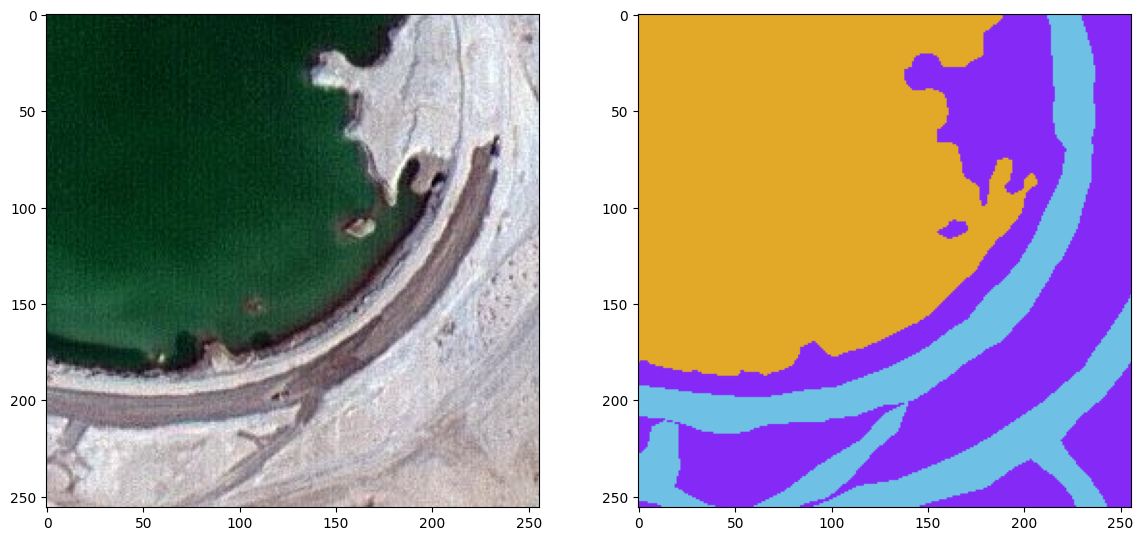

In [ ]:
#plotting the images
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
# Convert HEX values to RGB

# Define the HEX values for each class
class_building = '#3C1098'
class_land = '#8429F6'
class_road = '#6EC1E4'
class_vegetation = '#FEDD3A'
class_water = '#E2A929'
class_unlabeled = '#9B9B9B'

# Remove the '#' character from the HEX values
class_building = class_building.lstrip('#')
class_land = class_land.lstrip('#')
class_road = class_road.lstrip('#')
class_vegetation = class_vegetation.lstrip('#')
class_water = class_water.lstrip('#')
class_unlabeled = class_unlabeled.lstrip('#')

# Convert the HEX values to RGB arrays
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))

# Print the RGB values for each class
print("Class Building RGB:", class_building)
print("Class Land RGB:", class_land)
print("Class Road RGB:", class_road)
print("Class Vegetation RGB:", class_vegetation)
print("Class Water RGB:", class_water)
print("Class Unlabeled RGB:", class_unlabeled)


[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
label = individual_patched_mask

In [ ]:
def rgb_to_label(label):
  # Initialize an array to store the segmented label
  label_segment = np.zeros(label.shape, dtype=np.uint8)

  # Assign the corresponding class index to each RGB value in the label image
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5

  # Convert the segmented label to a single-channel grayscale image
  label_segment = label_segment[:,:,0]

  # Return the segmented label
  return label_segment


In [ ]:
labels = [ ]
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
labels = np.array(labels)

In [ ]:
print(len(labels)) #totalimages

945


In [ ]:
labels[3]


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [ ]:
labels[0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [ ]:
labels[1]

array([[1, 5, 5, ..., 0, 0, 0],
       [1, 5, 5, ..., 0, 0, 0],
       [1, 1, 5, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]], dtype=uint8)

In [ ]:
labels = np.expand_dims(labels, axis=3)

In [ ]:
labels[1]

array([[[1],
        [5],
        [5],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [5],
        [5],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [1],
        [5],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [2]],

       [[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [2]],

       [[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [2]]], dtype=uint8)

In [ ]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


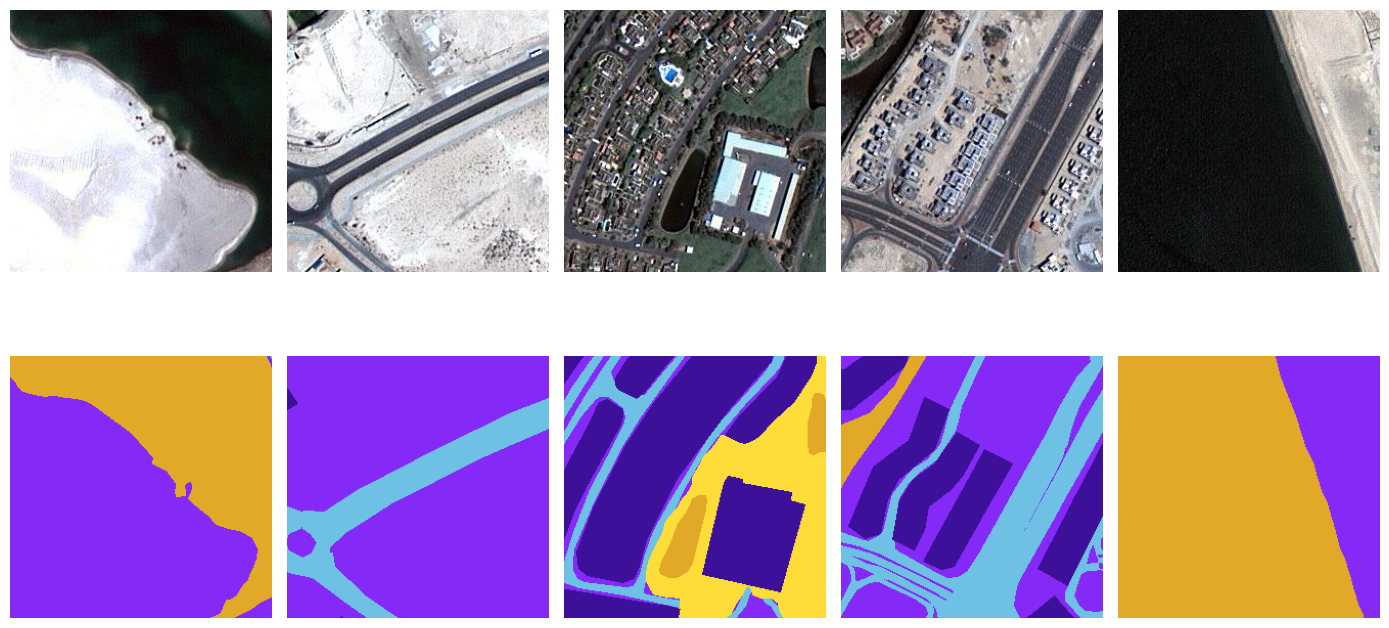

In [ ]:
# Select 5 random image indices
random_indices = random.sample(range(len(image_dataset)), 5)

# Create a subplot grid for the images and masks
plt.figure(figsize=(14, 8))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(image_dataset[idx])
    plt.axis('off')
    plt.subplot(2, 5, i + 5)
    plt.imshow(mask_dataset[idx])
    plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
total_classes = len(np.unique(labels))

In [ ]:

labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)


In [ ]:
master_training_dataset = image_dataset


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#test size=30%, train size= 70%
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.3, random_state=100)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [ ]:
print(X_train.shape) #distribution of 945 images into train and test
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [ ]:
master_training_dataset.shape

(945, 256, 256, 3)

# **MODEL TRAINING**

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K

In [ ]:
#Evaluation metrics
def jaccard_coef(y_true, y_pred):  #Intersection over union(IoU)
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
  # Input layer
  inputs = Input((image_height, image_width, image_channels))
  source_input = inputs

  # Encoder
  # Block 1
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.3)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  # Block 2
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.3)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  # Block 3
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.3)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  # Block 4
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.3)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  # Bottleneck
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  # Decoder
  # Block 6
  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.3)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  # Block 7
  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.3)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  # Block 8
  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.3)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  # Block 9
  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.3)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  # Output layer
  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  # Create the model
  model = Model(inputs=[inputs], outputs=[outputs])
  return model


In [ ]:
model.summary()

NameError: ignored

In [ ]:
metrics=["accuracy", jaccard_coef]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model= get_deep_learning_model()

In [ ]:
#model.get_config()

# **`Generating loss function`**
Equal class weights->Dice loss->Focal loss->Total Loss= (Dice loss + (1*Focal loss))

In [ ]:
weights=[0.166,0.166,0.166,0.166,0.166,0.166]

In [ ]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
dice_loss= sm.losses.DiceLoss(class_weights=weights)

In [ ]:
focal_loss= sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss=dice_loss + (1 * focal_loss)

# **Model Compilation**

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)

In [ ]:

# Split the data into train and test sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.3, random_state=100)

# Combine the train and test sets for cross-validation
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Define the number of folds
num_folds = 5

# Initialize the KFold object
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize a list to store the cross-validation scores
cv_scores = []

# Iterate over the folds
for train_indices, test_indices in kfold.split(X):
    # Split the data into train and test sets for the current fold
    X_train_fold, X_test_fold = X[train_indices], X[test_indices]
    y_train_fold, y_test_fold = y[train_indices], y[test_indices]

    # Train your model on the training data for the current fold
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    # Evaluate the model on the test data for the current fold
    score = jaccard_coef(y_test_fold, y_pred)

    # Store the score in the list
    cv_scores.append(score)

# Calculate the mean and standard deviation of the scores
mean_score = sum(cv_scores) / num_folds
std_dev = np.std(cv_scores)

# Print the results
print("Cross-validation scores:", cv_scores)
print("Mean score:", mean_score)
print("Standard deviation:", std_dev)


6/6 [==============================] - 3s 478ms/step
Cross-validation scores: [<tf.Tensor: shape=(), dtype=float32, numpy=0.26810125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.27808687>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3130745>, <tf.Tensor: shape=(), dtype=float32, numpy=0.42072153>, <tf.Tensor: shape=(), dtype=float32, numpy=0.411683>]
Mean score: tf.Tensor(0.33833343, shape=(), dtype=float32)
Standard deviation: 0.06537305


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

# **Model Training**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
model_history=model.fit(X_train,y_train,batch_size=16,epochs=15,verbose=1,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/15
42/42 [==============================] - 107s 3s/step - loss: 0.9681 - accuracy: 0.7018 - jaccard_coef: 0.4232 - val_loss: 0.9734 - val_accuracy: 0.6472 - val_jaccard_coef: 0.3891
Epoch 2/15
42/42 [==============================] - 106s 3s/step - loss: 0.9622 - accuracy: 0.7112 - jaccard_coef: 0.4477 - val_loss: 0.9794 - val_accuracy: 0.6646 - val_jaccard_coef: 0.3975
Epoch 3/15
42/42 [==============================] - 107s 3s/step - loss: 0.9581 - accuracy: 0.7305 - jaccard_coef: 0.4761 - val_loss: 0.9797 - val_accuracy: 0.6571 - val_jaccard_coef: 0.3698
Epoch 4/15
42/42 [==============================] - 106s 3s/step - loss: 0.9536 - accuracy: 0.7446 - jaccard_coef: 0.4963 - val_loss: 0.9707 - val_accuracy: 0.6993 - val_jaccard_coef: 0.4445
Epoch 5/15
42/42 [==============================] - 108s 3s/step - loss: 0.9505 - accuracy: 0.7526 - jaccard_coef: 0.5104 - val_loss: 0.9676 - val_accuracy: 0.7236 - val_jaccard_coef: 0.4715
Epoch 6/15
42/42 [===========================

In [ ]:
checkpoint = ModelCheckpoint(Model, monitor="test_accuracy", verbose=1, save_best_only=True, mode="max")
checkpoint

In [ ]:
history_a=model_history

In [ ]:
history_a.history

{'loss': [1.0021315813064575,
  0.9861983060836792,
  0.9670984148979187,
  0.9581298232078552,
  0.9537639021873474,
  0.9503422975540161,
  0.9477536678314209,
  0.9445356130599976,
  0.9423103928565979,
  0.9392703771591187],
 'accuracy': [0.5524634122848511,
  0.6205799579620361,
  0.7064605951309204,
  0.7280560731887817,
  0.7441524863243103,
  0.7531277537345886,
  0.7586716413497925,
  0.7657989859580994,
  0.774122416973114,
  0.7817902565002441],
 'jaccard_coef': [0.25851181149482727,
  0.34641680121421814,
  0.4380565285682678,
  0.4764101505279541,
  0.4927274286746979,
  0.5089130401611328,
  0.5205927491188049,
  0.5440651178359985,
  0.5552706122398376,
  0.5705055594444275],
 'val_loss': [0.9942806363105774,
  0.9879357814788818,
  0.9768672585487366,
  0.9788013696670532,
  0.9903291463851929,
  0.9930624961853027,
  0.989594578742981,
  0.9985304474830627,
  0.9957506656646729,
  0.9870328307151794],
 'val_accuracy': [0.5500364899635315,
  0.6810119152069092,
  0.6891

In [ ]:
loss=history_a.history['loss']

In [ ]:
loss #training_loss

[1.0021315813064575,
 0.9861983060836792,
 0.9670984148979187,
 0.9581298232078552,
 0.9537639021873474,
 0.9503422975540161,
 0.9477536678314209,
 0.9445356130599976,
 0.9423103928565979,
 0.9392703771591187]

In [ ]:
test_loss=history_a.history['val_loss']

In [ ]:
test_loss #validation_loss

[0.9942806363105774,
 0.9879357814788818,
 0.9768672585487366,
 0.9788013696670532,
 0.9903291463851929,
 0.9930624961853027,
 0.989594578742981,
 0.9985304474830627,
 0.9957506656646729,
 0.9870328307151794]

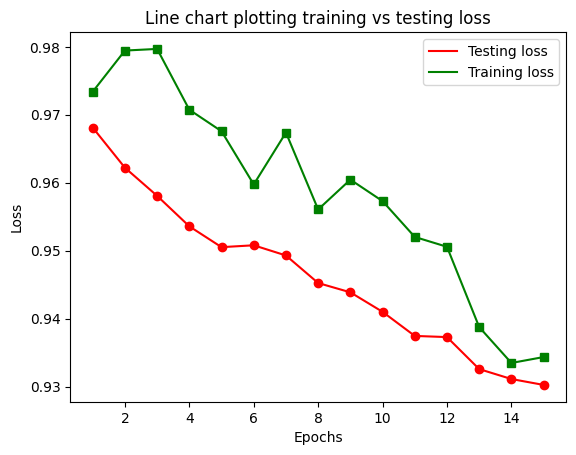

In [ ]:
loss=history_a.history['loss']
test_loss=history_a.history['val_loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs,loss,'r',label="Testing loss")
plt.plot(epochs,loss,'ro')
plt.plot(epochs,test_loss,'g',label='Training loss')
plt.plot(epochs,test_loss,'gs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Line chart plotting training vs testing loss')
plt.show()

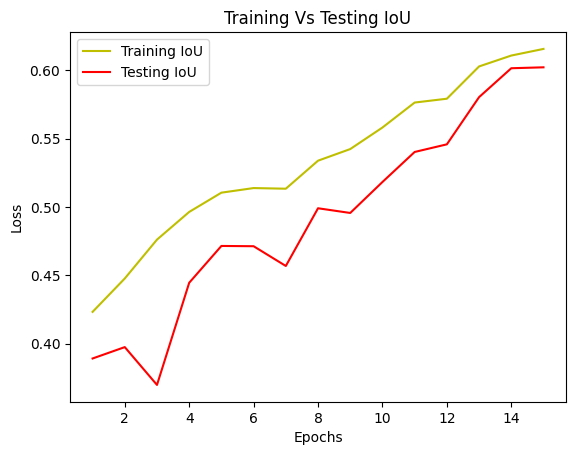

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
test_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, test_jaccard_coef, 'r', label="Testing IoU")
plt.title("Training Vs Testing IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 15, 'steps': 42}

**Performing Predictions**

In [ ]:
y_predict=model.predict(X_test)

9/9 [==============================] - 4s 452ms/step


In [ ]:
len(y_predict)

142

In [ ]:
y_predict

array([[[[1.13812260e-01, 4.38969404e-01, 1.78891674e-01,
          5.40293381e-02, 1.14284433e-01, 1.00012869e-01],
         [4.89150584e-02, 4.85669017e-01, 1.55479550e-01,
          7.38140866e-02, 8.41205940e-02, 1.52001649e-01],
         [9.99346450e-02, 4.44001526e-01, 1.58716172e-01,
          8.86483118e-02, 1.40730813e-01, 6.79685324e-02],
         ...,
         [1.88296974e-01, 1.88255668e-01, 1.60391971e-01,
          1.72176939e-02, 4.30124551e-01, 1.57131813e-02],
         [1.92113370e-01, 1.83212727e-01, 1.56735376e-01,
          2.11818814e-02, 4.31091875e-01, 1.56647842e-02],
         [1.92769006e-01, 1.75720140e-01, 1.62253335e-01,
          4.55751903e-02, 3.92563909e-01, 3.11184265e-02]],

        [[7.60261118e-02, 5.44655502e-01, 1.61566079e-01,
          3.13583054e-02, 6.71873838e-02, 1.19206615e-01],
         [2.68570799e-02, 6.21636868e-01, 1.54741019e-01,
          4.70884703e-02, 5.13746366e-02, 9.83019024e-02],
         [6.29001930e-02, 5.40930450e-01, 1.8558

In [ ]:
y_pred_argmax=np.argmax(y_predict, axis=3)

In [ ]:
len(y_pred_argmax)

142

In [ ]:
y_pred_argmax

array([[[1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [4, 0, 0, ..., 0, 0, 0]],

       [[2, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 2, 4, 4],
        [4, 2, 1, ..., 2, 2, 4],
        ...,
        [4, 4, 4, ..., 4, 0, 0],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       ...,

       [[4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# **Comparing Prediction results**

In [ ]:
import random


In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 48ms/step


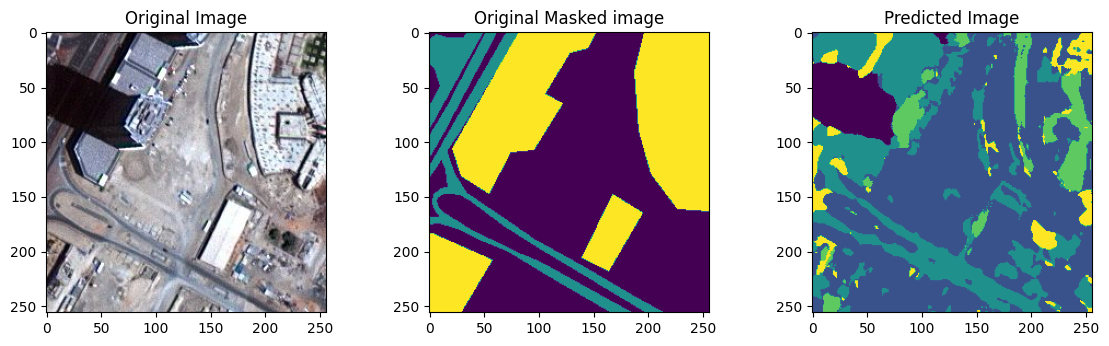

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
model.save("satellite_segmentation_full.h5")